# Martian Frost HiRISE Image Classification
* Data confidence weighting
* Predicts frost_context probabilities

Outside of built-in python 3 libraries, this code uses numpy, skimage, tqdm, PIL, matplotlib, and tensorflow.

In [2]:
import os
import os.path as op
import json
from pathlib import Path
import shutil
import logging

import numpy as np
from tqdm import tqdm
from skimage import io

# Logging configuration
logging.basicConfig(level=logging.INFO,
                    datefmt='%H:%M:%S',
                    format='%(asctime)s | %(levelname)-5s | %(module)-15s | %(message)s')

IMAGE_SIZE = (299, 299)  # All images contained in this dataset are 299x299 (originally, to match Inception v3 input size)
SEED = 17

# Head directory containing all image subframes
data_head_dir = Path('./data')

# Find all subframe directories
subdirs = [Path(subdir.stem) for subdir in data_head_dir.iterdir() if subdir.is_dir()]
src_image_ids = ['_'.join(a_path.name.split('_')[:3]) for a_path in subdirs]

# Suggested Data Split

Use the suggested train/val/test split to avoid data leakage across each data subset from a geospatial perspective.

In [3]:
# Load train/val/test subframe IDs
def load_text_ids(file_path):
    """Simple helper to load all lines from a text file"""
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f.readlines()]
    return lines

# Load the subframe names for the three data subsets
train_ids = load_text_ids('./splits/train_source_images.txt')
validate_ids = load_text_ids('./splits/val_source_images.txt')
test_ids = load_text_ids('./splits/test_source_images.txt')

## Create frost context array helper functions
These will help us decode and encode the frost context arrays that are stored in the jsons.
Will also be used for data visualization

In [4]:
# [defrosting marks, halos, polygonal cracks, slab ice cracks, uniform albedo, other]
# convert string to index
def get_context_idx(str):
    if (str == 'defrosting_marks'):
        return 0
    elif (str == 'halos'):
        return 1
    elif (str == 'polygonal_cracks'):
        return 2
    elif (str == 'slab_ice_cracks'):
        return 3
    elif (str == 'uniform_albedo'):
        return 4
    elif (str == 'other'):
        return 5
    
# convert annotations to frost context entry
def get_category_format(data):
    entry = [0, 0, 0, 0, 0, 0]
    for k in range(len(data['frost_types'])):
        if data['frost_types'][k] == 'defrosting_marks':
            entry[0] = 1
        elif data['frost_types'][k] == 'halos':
            entry[1] = 1
        elif data['frost_types'][k] == 'polygonal_cracks':
            entry[2] = 1
        elif data['frost_types'][k] == 'slab_ice_cracks':
            entry[3] = 1
        elif data['frost_types'][k] == 'uniform_albedo':
            entry[4] = 1
        elif data['frost_types'][k] == 'other':
            entry[5] = 1
    return entry

# convert frost context entry to sentence for readability
def decode_array_to_context(arr):
    context = ''
    if arr[0] == 1:
        context += 'defrosting marks, '
    if arr[1] == 1:
        context += 'halos, '
    if arr[2] == 1:
        context += 'polygonal cracks, '
    if arr[3] == 1:
        context += 'slab ice cracks, '
    if arr[4] == 1:
        context += 'uniform albedo, '
    if arr[5] == 1:
        context += 'other, '
    # Remove the last 2 characters from the string
    context = context[:-2]
    if context == '':
        context = 'no frost'
    return context


def get_pred_format(arr):
    context = ''
    if arr[0] != 0:
        context += f'defrosting marks: {np.round(arr[0]*100)}%\n'
    if arr[1] != 0:
        context += f'halos: {np.round(arr[1]*100)}%\n'
    if arr[2] != 0:
        context += f'polygonal cracks: {np.round(arr[2]*100)}%\n'
    if arr[3] != 0:
        context += f'slab ice cracks: {np.round(arr[3]*100)}%\n'
    if arr[4] != 0:
        context += f'uniform albedo: {np.round(arr[4]*100)}%\n'
    if arr[5] != 0:
        context += f'other: {np.round(arr[5]*100)}%\n'
    # Remove the last newline from string
    if context == '':
        context = 'no frost (~0%)\n'
    context = context[:-1]
    return context


## Prepare data as numpy arrays

Load the data and pair a tile with its label. Each tile is stored in a numpy array under its parent. Each tile is a data object containing the following parameters:
* `tile`: the png image data
* `label`: the entire json for the tile
* `class`: the class of the tile
* `file`: the filename of the tile
* `data`: the json annotations
* `frost_types`: formatted 6-length array of frost contexts

## Add weight to labeller confidence
* Low confidence: 4.0
* Medium confidence: 7.0
* High confidence: 1.0
* Multiply by overlap proportion
* Compute the average weight for each frost type with confidence
Assign a cutoff value of 0.5. I.e. if the 'uniform_albedo' has
a score of 0.8, consider it a 1. If it's 0.3, consider it a 0

In [5]:
from skimage import io, color
# modified this function to pair a tile with its label

# define the cutoff hyperparameter
cutoff = 0.5

def load_images(dir_path):

    tile_dir = dir_path / Path('tiles')
    images = {'file': dir_path.stem, 'class': '', 'tiles': []}

    for root, dirs, files in os.walk(tile_dir):
        for file in files:
            file = Path(file)
            if file.suffix == '.png':
                fp = os.path.join(root, file)
                
                # Extract the image class label from the filepath. This (and additional) info is also in the label jsons
                image_class = Path(root).stem
                if images['class'] == '':
                    images['class'] = image_class
                
                # Load the image, save it to our list

                img = io.imread(fp)

                # locate the associated label json
                label_fp = op.join(dir_path, 'labels', image_class, f'{file.stem}.json')
                with open(label_fp, 'r') as f:
                    label_json = json.load(f)

                # determine what frost types are present
                frost_data = [0,0,0,0,0,0]
                # Get the polygons
                annotations = label_json['annotations']
                for i in range(len(annotations)):
                    this_overlap = annotations[i]['overlap_proportion']
                    weight = 0
                    if "low" in annotations[i]['confidence']:
                        weight = 0.4
                    elif "med" in annotations[i]['confidence']:
                        weight = 0.7
                    elif "high" in annotations[i]['confidence']:
                        weight = 1.0
                    for j in range(len(annotations[i]['frost_context'])):
                        frost_data[get_context_idx(annotations[i]
                                   ['frost_context'][j])] += (weight*this_overlap)
                
                # average the frost data
                # if it exists!
                if len(annotations) > 0:
                    frost_data = [x / len(annotations) for x in frost_data]

                # compute the hard value at which we consider it a 1
                # set to 0.5 for now
                for i in range(len(frost_data)):
                    if frost_data[i] >= cutoff:
                        frost_data[i] = 1
                    else:
                        frost_data[i] = 0

                combined_entry = {"tile": img,
                                  "data": label_json, 
                                  "class": image_class,
                                  "file": file.stem,
                                  "frost_types": frost_data}
                
                images['tiles'].append(combined_entry)

    return images

## Split the data into train/val/test
Make use of load_images above and bin the data properly. It will bin according to the txt files imported above.

In [6]:
train_data = []
validate_data = []
test_data = []
logging.info(f'Loading ML data from {len(subdirs)} subframes.')
for subdir in tqdm(subdirs, desc='Creating Dataset as Numpy array'):
    full_path = data_head_dir / subdir
    for i in range(len(train_ids)):
        if train_ids[i] in str(full_path):
            train_data.append(load_images(full_path))
    for j in range(len(validate_ids)):
        if validate_ids[j] in str(full_path):
            validate_data.append(load_images(full_path))
    for k in range(len(test_ids)):
        if test_ids[k] in str(full_path):
            test_data.append(load_images(full_path))


13:43:02 | INFO  | 1632450843      | Loading ML data from 214 subframes.
Creating Dataset as Numpy array: 100%|██████████| 214/214 [01:31<00:00,  2.33it/s]


## Check the size of each bin
Just to check and make sure we binned correctly!

In [7]:
if (len(train_data) + len(validate_data) + len(test_data)) != 214:
    print("Error: Data not loaded and/or binned correctly")
else:
    print("Good to go!")
    # print all lengths, and the amount with frost/background class
    print(f"    -> Train size: {len(train_data)}")
    print(f"    -> Validate size: {len(validate_data)}")
    print(
        f"    -> Test size: {len(test_data)}")


Good to go!
    -> Train size: 102
    -> Validate size: 55
    -> Test size: 57


## Print a random tile and its frost context
Print a random tile and its data to make sure everything is working properly.

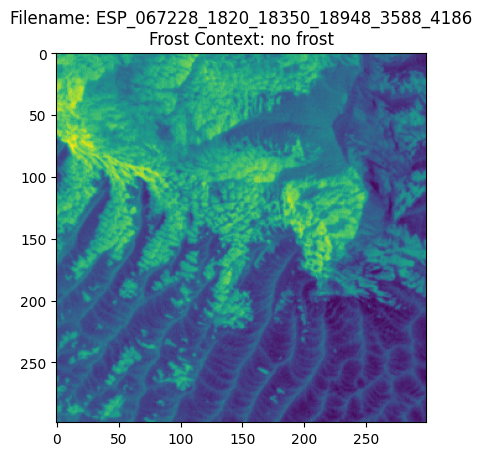

In [8]:
from shapely import wkt
from descartes import PolygonPatch
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import random

def display_random_image_and_json(some_data):
    # Pick a random image that has frost
    idx = random.choice(range(len(some_data)))
    tile_i = random.choice(range(len(some_data[idx]['tiles'])))
    img_dict = some_data[idx]['tiles'][tile_i]

    img = img_dict['tile']

    # Plot the image
    fig, ax = plt.subplots()
    ax.imshow(img)

    # Set the title
    ax.set_title(
        f"Filename: {img_dict['file']}\nFrost Context: {decode_array_to_context(img_dict['frost_types'])}")

    plt.show()


display_random_image_and_json(train_data)


## Preprocess data

Gather and bin the data

In [9]:
# frost type categories = [defrosting marks, halos, polygonal cracks, slab ice cracks, uniform albedo, other]

# Train Data
X_train = []
y_train = []
for i in range(len(train_data)):
    for j in range(len(train_data[i]['tiles'])):
        X_train.append(train_data[i]['tiles'][j]['tile'])
        y_train.append(train_data[i]['tiles'][j]['frost_types'])

# Validate Data
X_val = []
y_val = []
for i in range(len(validate_data)):
    for j in range(len(validate_data[i]['tiles'])):
        X_val.append(validate_data[i]['tiles'][j]['tile'])
        y_val.append(validate_data[i]['tiles'][j]['frost_types'])

# Test Data
X_test = []
y_test = []
for i in range(len(test_data)):
    for j in range(len(test_data[i]['tiles'])):
        X_test.append(test_data[i]['tiles'][j]['tile'])
        y_test.append(test_data[i]['tiles'][j]['frost_types'])

Format the data

In [10]:
# Convert lists to numpy array
X_train = np.array(X_train)
X_val = np.array(X_val)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

# Normalize the data
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Reshape the data
X_train = X_train.reshape(-1,299,299,1)
X_val = X_val.reshape(-1, 299, 299, 1)
X_test = X_test.reshape(-1, 299, 299, 1)

###### Shuffle the training set ######
indices = np.arange(X_train.shape[0])

# First shuffle the indices
np.random.shuffle(indices)

# Then use the shuffled indices to shuffle data and labels
X_train = X_train[indices]
y_train = y_train[indices]

Make sure it's formatted correctly

In [11]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(14119, 299, 299, 1)
(14119, 6)
(7889, 299, 299, 1)
(7889, 6)
(7972, 299, 299, 1)
(7972, 6)


## Create Hamming Loss and Presence Metrics

In [12]:
import tensorflow as tf
# Hamming loss metric


def hamming_loss(y_true, y_pred):
    y_pred_binary = tf.cast(y_pred >= 0.5, dtype=tf.float32)
    elementwise_equal = tf.equal(y_true, y_pred_binary)
    false_count = tf.reduce_sum(
        tf.cast(tf.logical_not(elementwise_equal), dtype=tf.float32))
    # Divide by total number of labels
    loss = false_count / tf.cast(tf.size(y_true), dtype=tf.float32)
    return loss


def frost_presence_accuracy(y_true, y_pred):
    # Convert predictions to binary
    y_pred_binary = tf.cast(y_pred >= 0.5, dtype=tf.float32)

    # Compute sums of true and predicted labels
    y_true_sum = tf.reduce_sum(y_true, axis=-1)
    y_pred_sum = tf.reduce_sum(y_pred_binary, axis=-1)

    # Compute boolean tensors where True indicates that the sum of labels are either both zero or both non-zero
    sums_are_both_zero = tf.logical_and(
        tf.equal(y_true_sum, 0), tf.equal(y_pred_sum, 0))
    sums_are_both_non_zero = tf.logical_and(
        tf.not_equal(y_true_sum, 0), tf.not_equal(y_pred_sum, 0))

    # Combine the two conditions
    correct_condition = tf.logical_or(
        sums_are_both_zero, sums_are_both_non_zero)

    # Cast boolean tensor to float32 and compute mean
    accuracy = tf.reduce_mean(tf.cast(correct_condition, dtype=tf.float32))

    return accuracy

2023-07-05 13:46:36.585478: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Augment the data

In [16]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [13]:
# Define the data augmentation parameters
aug_imgs = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True
)

aug_imgs.fit(X_train)

## Create the CNN

In [14]:
num_classes = 6

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu',
          input_shape=(299, 299, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='sigmoid'))

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=[hamming_loss, frost_presence_accuracy])

## Train the model

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

# early_stop = EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(X_train, y_train, epochs=10, batch_size=100,
                         validation_data=(X_val, y_val))

Epoch 1/5
142/142 [==============================] - 313s 2s/step - loss: 0.2507 - hamming_loss: 0.1270 - frost_presence_accuracy: 0.6475 - val_loss: 0.3004 - val_hamming_loss: 0.0890 - val_frost_presence_accuracy: 0.8604
Epoch 2/5
142/142 [==============================] - 395s 3s/step - loss: 0.2024 - hamming_loss: 0.0965 - frost_presence_accuracy: 0.7413 - val_loss: 0.3774 - val_hamming_loss: 0.0990 - val_frost_presence_accuracy: 0.8500
Epoch 3/5
142/142 [==============================] - 416s 3s/step - loss: 0.1808 - hamming_loss: 0.0838 - frost_presence_accuracy: 0.7879 - val_loss: 0.4413 - val_hamming_loss: 0.1310 - val_frost_presence_accuracy: 0.7631
Epoch 4/5
142/142 [==============================] - 404s 3s/step - loss: 0.1913 - hamming_loss: 0.0940 - frost_presence_accuracy: 0.7466 - val_loss: 0.3791 - val_hamming_loss: 0.0923 - val_frost_presence_accuracy: 0.8556
Epoch 5/5
142/142 [==============================] - 421s 3s/step - loss: 0.1578 - hamming_loss: 0.0755 - frost_

## Save the weights as a .h5 file
Also save the history of the model as a .csv file

In [25]:
import pandas as pd
model.save('10_100_32-64-64-256-32.h5')
# Convert the history.history dict to a pandas DataFrame
hist_df = pd.DataFrame(history.history)

# Save to csv
hist_csv_file = '10_100_32-64-64-256-32.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
/var/folders/cb/0n1k7bbx32zc6f4_p5bcw3xm0000gn/T/ipykernel_2793/284654139.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hist_df = hist_df.append(hist_df2)


## Evaluate the model
Using our custom metrics. Load in the file.

In [13]:
import pandas as pd
from tensorflow.keras.models import load_model

# Register the custom metric function
with tf.keras.utils.custom_object_scope({'hamming_loss': hamming_loss, 'frost_presence_accuracy': frost_presence_accuracy}):
    my_model = load_model('10_100_32-64-64-256-32.h5')

my_model_history = pd.read_csv(
    '10_100_32-64-64-256-32.csv')


## Random prediction models (2)
* Predict all 0's
* Choose 0's and 1's at random
* Demonstrates how much better our model is than random

In [14]:
def predict_zeros(X_data):
    # return an array of [0,0,0,0,0,0] for each X_train
    return np.zeros((X_data.shape[0], 6))

def predict_random(X_data):
    # return an array of random 0's and 1's [x,x,x,x,x,x] for each X_train
    return np.random.choice([0, 1], size=(X_data.shape[0], 6))


Generate predictions for 3 models

In [15]:
predict_zeros = predict_zeros(X_test)
predict_random = predict_random(X_test)
predictions = my_model.predict(X_test)

250/250 [==============================] - 99s 392ms/step


Decide % cutoff for CNN prediction

In [58]:
predictions_decimal = np.round(predictions, 2)
predictions_round = np.where(predictions >= 0.6, 1, 0)

## Compare all three models

In [59]:
import numpy as np
from keras.models import load_model
from sklearn.metrics import hamming_loss

# Compute the Hamming loss for each predictor
hamming_loss_zeros = hamming_loss(y_test, predict_zeros)
hamming_loss_random = hamming_loss(y_test, predict_random)
hamming_loss_cnn = hamming_loss(y_test, predictions_round)

fp_acc_zeros = frost_presence_accuracy(y_test, predict_zeros)
fp_acc_random = frost_presence_accuracy(y_test, predict_random)
fp_acc_cnn = frost_presence_accuracy(y_test, predictions_round)
# print all
print(f"Hamming Loss for Zeros: {hamming_loss_zeros}")
print(f"Hamming Loss for Random: {hamming_loss_random}")
print(f"Hamming Loss for CNN: {hamming_loss_cnn}")

print(f"Frost Presence Accuracy for Zeros: {fp_acc_zeros}")
print(f"Frost Presence Accuracy for Random: {fp_acc_random}")
print(f"Frost Presence Accuracy for CNN: {fp_acc_cnn}")

Hamming Loss for Zeros: 0.16965629703963875
Hamming Loss for Random: 0.5005853821709316
Hamming Loss for CNN: 0.11975246696772035
Frost Presence Accuracy for Zeros: 0.36615654826164246
Frost Presence Accuracy for Random: 0.6295785307884216
Frost Presence Accuracy for CNN: 0.7945308685302734


## Display 20 test images and the predictions

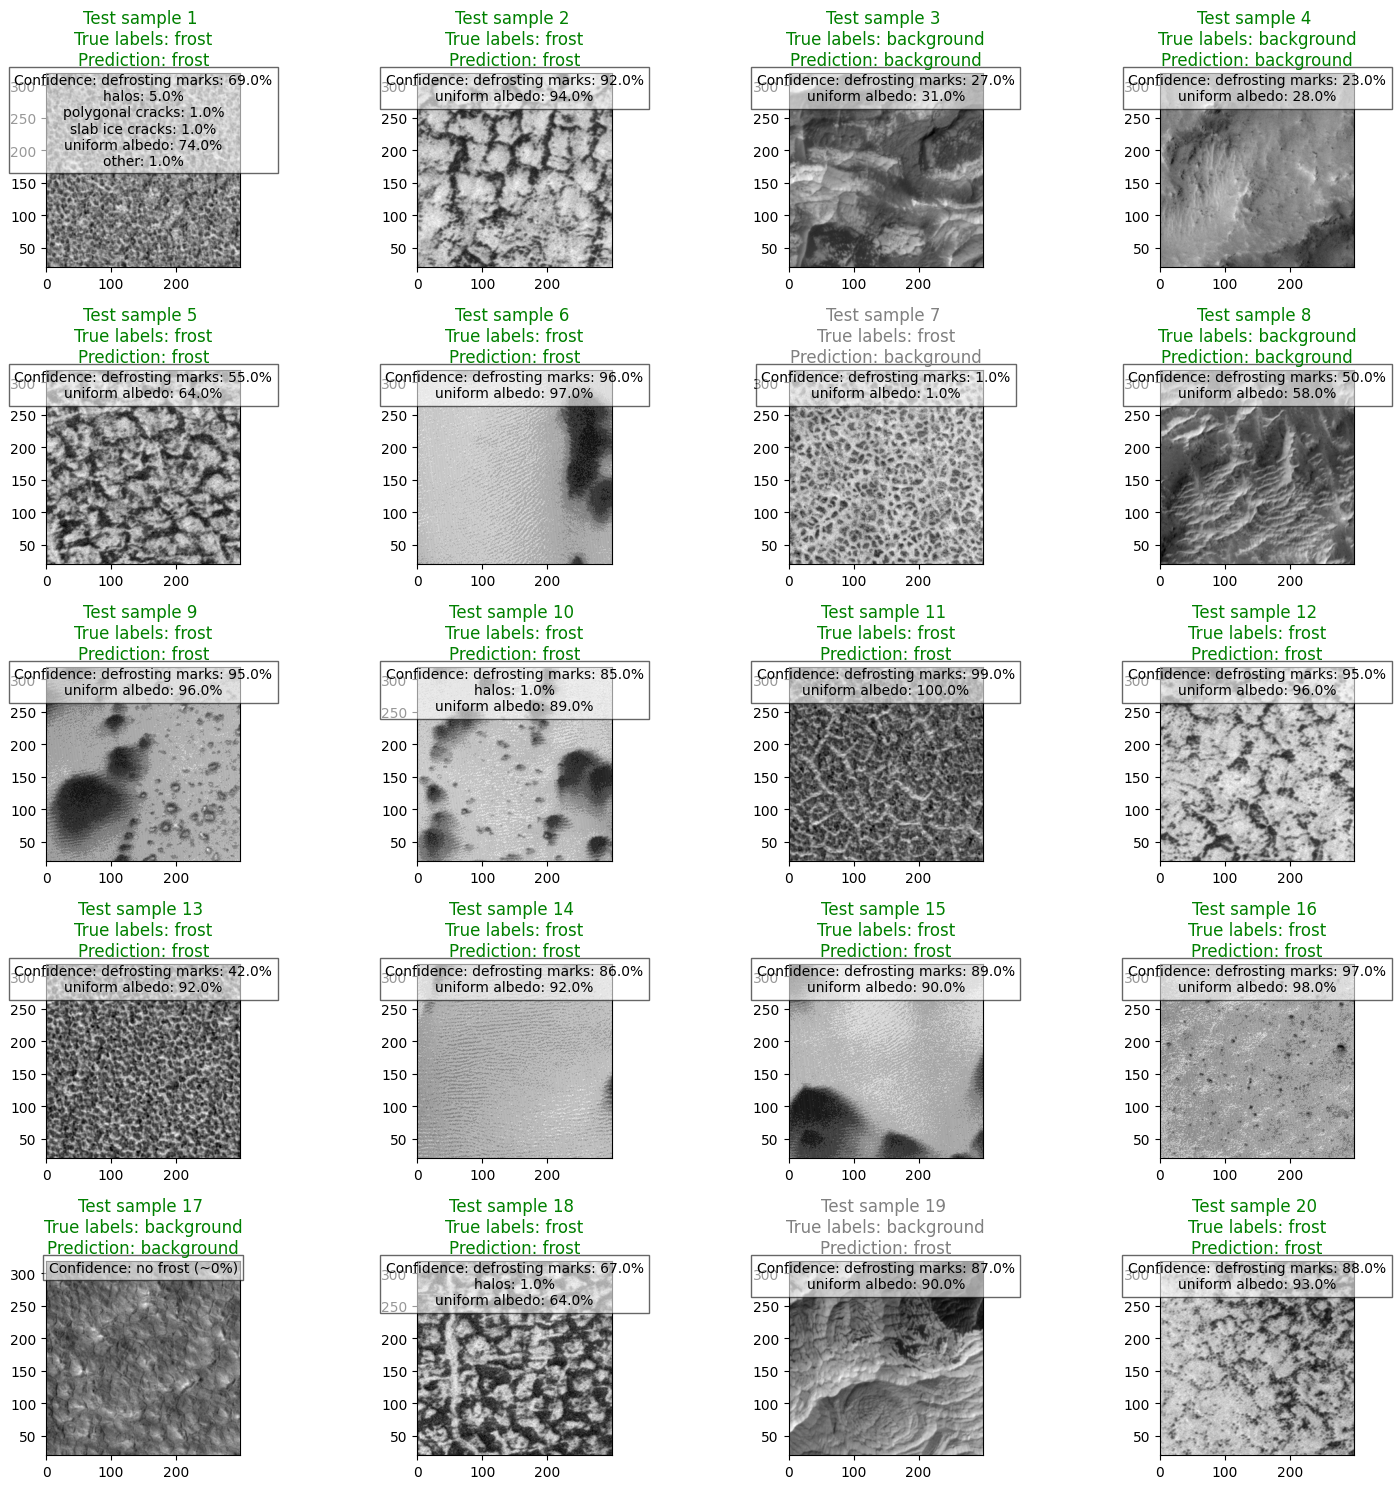

In [60]:
from matplotlib import pyplot as plt

def get_class(arr):
    # sum the array
    sum = np.sum(arr)
    # if sum is 0, return 'None'
    if sum == 0:
        return 'background'
    elif sum > 0:
        return 'frost'


# randomly choose 20 samples in the test set
random_index = np.random.choice(X_test.shape[0], 20)

# Create a figure with 5 rows and 4 columns
fig, axs = plt.subplots(5, 4, figsize=(15, 15))

for i, idx in enumerate(random_index):
    # Find the row and column for the current subplot
    row = i // 4
    col = i % 4

    # Display the image
    axs[row, col].imshow(X_test[idx].reshape(299, 299), cmap='gray', extent=[0, 299, 20, 319])

    # Set the title
    title = axs[row, col].set_title(
        f"Test sample {i+1} \nTrue labels: {get_class(y_test[idx])}\nPrediction: {get_class(predictions_round[idx])}")
    # If true label matches prediction, set color to green, else set to gray
    if get_class(y_test[idx]) == get_class(predictions_round[idx]):
        title.set_color('green')
    else:
        title.set_color('gray')

    # Add text box with prediction confidence
    axs[row, col].text(0.5, 1, f"Confidence: {get_pred_format(predictions_decimal[idx])}",
                       transform=axs[row, col].transAxes, ha='center', va='top',
                       bbox={'facecolor': 'white', 'alpha': 0.6})




# Remove any unused subplots
for i in range(len(random_index), 20):
    row = i // 4
    col = i % 4
    fig.delaxes(axs[row][col])

plt.tight_layout()
plt.show()


## Plot hamming loss and presence metrics

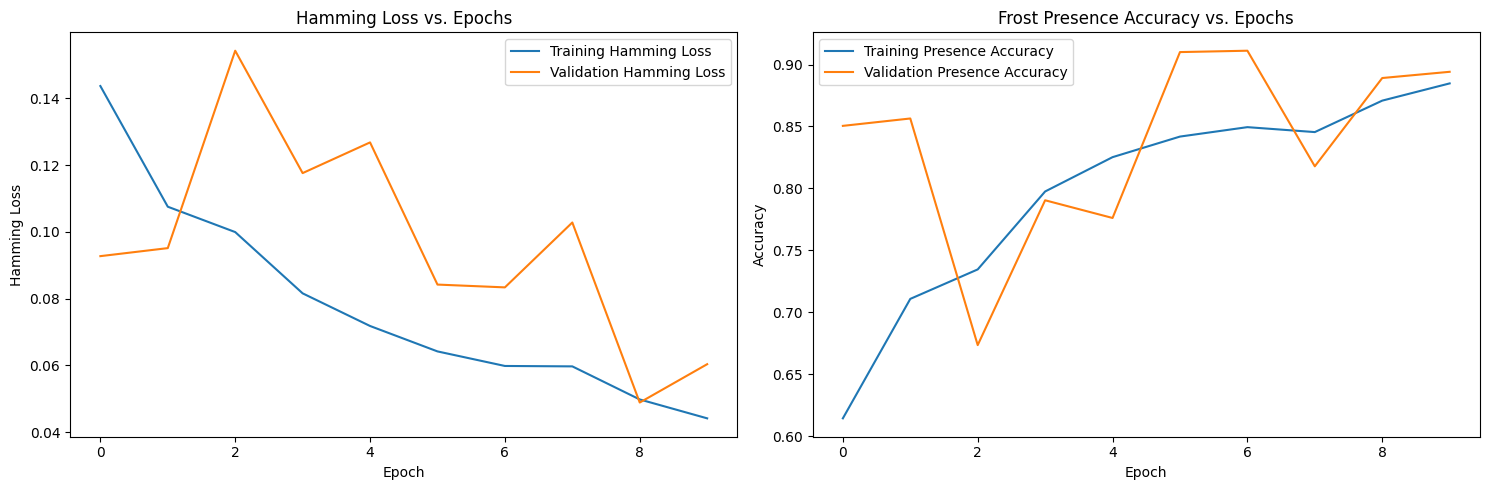

In [19]:
import matplotlib.pyplot as plt

# Create a new figure with a 1x2 grid of subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

# Plot the training and validation Hamming loss on the first subplot
axes[0].plot(my_model_history['hamming_loss'], label='Training Hamming Loss')
axes[0].plot(my_model_history['val_hamming_loss'],
             label='Validation Hamming Loss')

# Label the axes of the first subplot
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Hamming Loss')
axes[0].set_title('Hamming Loss vs. Epochs')

# Add a legend to the first subplot
axes[0].legend()

# Plot the training and validation accuracy on the second subplot
axes[1].plot(my_model_history['frost_presence_accuracy'],
             label="Training Presence Accuracy")
axes[1].plot(my_model_history['val_frost_presence_accuracy'],
             label="Validation Presence Accuracy")

# Label the axes of the second subplot
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Frost Presence Accuracy vs. Epochs')

# Add a legend to the second subplot
axes[1].legend()

# Display the plot
plt.tight_layout()
plt.show()
